# Thuật toán Đom đóm: Trực quan và Ứng dụng cho Rastrigin & Knapsack

**Mục tiêu:**

* Giải thích trực giác cốt lõi của Firefly Algorithm (FA)
* Minh họa cách FA khám phá không gian tìm kiếm trong 2D
* Trình diễn FA trên bài toán liên tục Rastrigin
* Trình diễn FA trên bài toán rời rạc Knapsack 0–1
* So sánh hành vi hội tụ giữa các loại bài toán

---


## 1. Firefly Algorithm là gì?

**Firefly Algorithm** (thuật toán Đom Đóm) là một thuật toán tối ưu metaheuristic lấy cảm hứng từ hành vi phát sáng của loài đom đóm.

**Các khái niệm cốt lõi:**

* Một quần thể **đom đóm** đại diện cho các nghiệm ứng viên
* Mỗi đom đóm có **độ sáng** tỉ lệ với giá trị hàm mục tiêu (fitness)
* Đom đóm **bị thu hút** bởi những con sáng hơn và di chuyển về phía chúng
* **Ngẫu nhiên** cho phép khám phá các vùng không gian mới

**Các phương trình chính:**

1. **Độ hấp dẫn** giảm theo khoảng cách:
   $$\beta(r) = \beta_0 \cdot e^{-\gamma r^2}$$

   * $\beta_0$: độ hấp dẫn gốc (thường là 1,0)
   * $\gamma$: hệ số hấp thụ ánh sáng (quy định tốc độ suy giảm hấp dẫn)
   * $r$: khoảng cách Euclid giữa hai đom đóm

2. **Cập nhật vị trí** khi đom đóm (i) bị thu hút bởi đom đóm sáng hơn (j):
   $$
   \mathbf{x}_i \leftarrow \mathbf{x}_i

   * \beta(r) (\mathbf{x}_j - \mathbf{x}_i)
   * \alpha \cdot \mathbf{\epsilon}
     $$

   - Thành phần đầu: vị trí hiện tại
   - Thành phần hai: lực hấp dẫn hướng về đom đóm sáng hơn
   - Thành phần ba: nhiễu ngẫu nhiên (hệ số (\alpha) điều khiển mức ngẫu nhiên, (\mathbf{\epsilon}) là nhiễu)

**Vai trò các tham số:**

* $\alpha$: điều khiển mức độ khám phá (cao → bước đi ngẫu nhiên mạnh hơn)
* $\beta_0$: điều khiển cường độ hấp dẫn
* $\gamma$: điều khiển phạm vi tương tác (cao → tìm kiếm mang tính cục bộ hơn)

---


## 2. Visual Demo: FA in 2D

Let's build a simple 2D Firefly Algorithm from scratch to visualize the movement pattern.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Define a 2D test function: shifted Rastrigin (for visual clarity)
def objective_2d(x, y):
    """2D Rastrigin-like function with optimum at (0, 0)"""
    return 20 + (x**2 - 10*np.cos(2*np.pi*x)) + (y**2 - 10*np.cos(2*np.pi*y))

# Simple FA implementation for 2D visualization
class SimpleFA2D:
    def __init__(self, n_fireflies=15, alpha=0.2, beta0=1.0, gamma=1.0, bounds=(-5, 5)):
        self.n = n_fireflies
        self.alpha = alpha
        self.beta0 = beta0
        self.gamma = gamma
        self.bounds = bounds
        
    def initialize(self):
        """Randomly initialize firefly positions"""
        low, high = self.bounds
        self.positions = np.random.uniform(low, high, (self.n, 2))
        
    def brightness(self, pos):
        """Calculate brightness (inverse of objective)"""
        return -objective_2d(pos[0], pos[1])  # Minimize objective
    
    def distance(self, pos_i, pos_j):
        """Euclidean distance"""
        return np.linalg.norm(pos_i - pos_j)
    
    def attractiveness(self, r):
        """Beta decreases with distance"""
        return self.beta0 * np.exp(-self.gamma * r**2)
    
    def run(self, iterations=30):
        """Run FA and store trajectory"""
        self.initialize()
        trajectory = [self.positions.copy()]
        
        for _ in range(iterations):
            # Calculate brightness for all fireflies
            brightness = np.array([self.brightness(pos) for pos in self.positions])
            
            # Move each firefly toward brighter ones
            new_positions = self.positions.copy()
            for i in range(self.n):
                for j in range(self.n):
                    if brightness[j] > brightness[i]:  # j is brighter than i
                        r = self.distance(self.positions[i], self.positions[j])
                        beta = self.attractiveness(r)
                        # Move i toward j with randomness
                        new_positions[i] += beta * (self.positions[j] - self.positions[i])
                        new_positions[i] += self.alpha * np.random.uniform(-1, 1, 2)
                
                # Keep within bounds
                new_positions[i] = np.clip(new_positions[i], *self.bounds)
            
            self.positions = new_positions
            trajectory.append(self.positions.copy())
        
        return trajectory

print("✓ Simple 2D FA implementation ready")

✓ Simple 2D FA implementation ready


In [7]:
# Run the 2D FA
fa_2d = SimpleFA2D(n_fireflies=15, alpha=0.2, beta0=1.0, gamma=1.0, bounds=(-5, 5))
trajectory = fa_2d.run(iterations=30)

print(f"Collected trajectory for {len(trajectory)} iterations")
print(f"Number of fireflies: {fa_2d.n}")

Collected trajectory for 31 iterations
Number of fireflies: 15


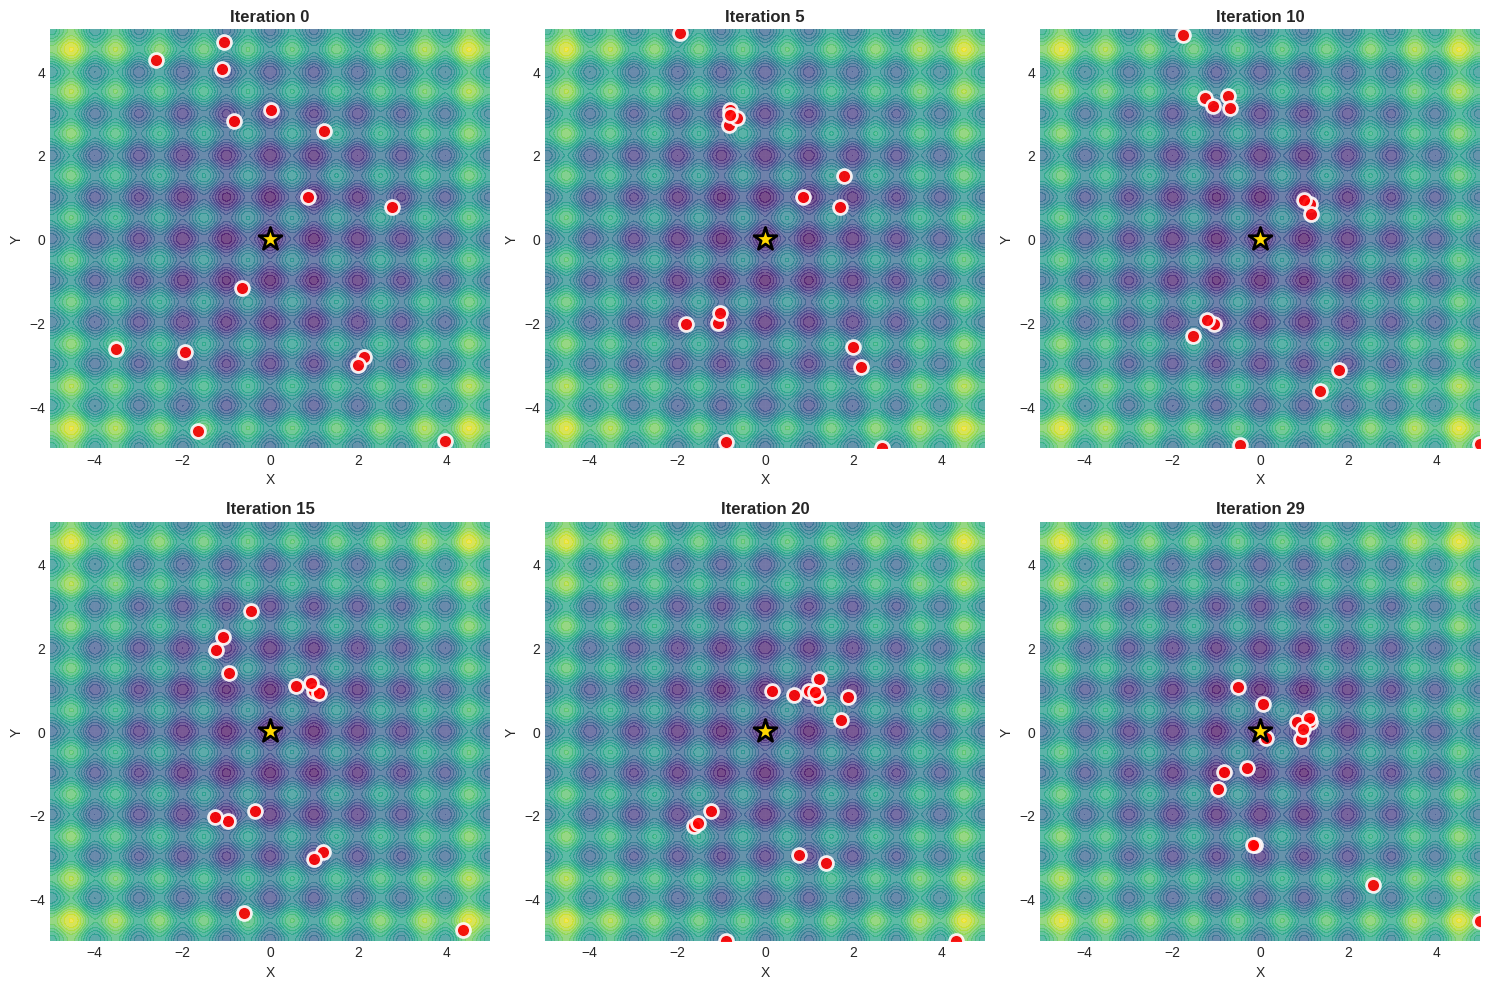

🔥 Notice how fireflies cluster around good regions and converge toward the optimum!


In [8]:
# Visualize: snapshots at key iterations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Create contour background
x = np.linspace(-5, 5, 200)
y = np.linspace(-5, 5, 200)
X, Y = np.meshgrid(x, y)
Z = objective_2d(X, Y)

# Snapshots at iterations: 0, 5, 10, 15, 20, 30
snapshot_iters = [0, 5, 10, 15, 20, 29]

for idx, iter_num in enumerate(snapshot_iters):
    ax = axes[idx]
    
    # Plot contour
    contour = ax.contourf(X, Y, Z, levels=20, cmap='viridis', alpha=0.7)
    
    # Plot fireflies at this iteration
    positions = trajectory[iter_num]
    ax.scatter(positions[:, 0], positions[:, 1], c='red', s=100, 
              edgecolors='white', linewidth=2, marker='o', zorder=5, alpha=0.9)
    
    # Mark global optimum
    ax.scatter(0, 0, c='gold', s=300, marker='*', 
              edgecolors='black', linewidth=2, zorder=10)
    
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'Iteration {iter_num}', fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("🔥 Notice how fireflies cluster around good regions and converge toward the optimum!")

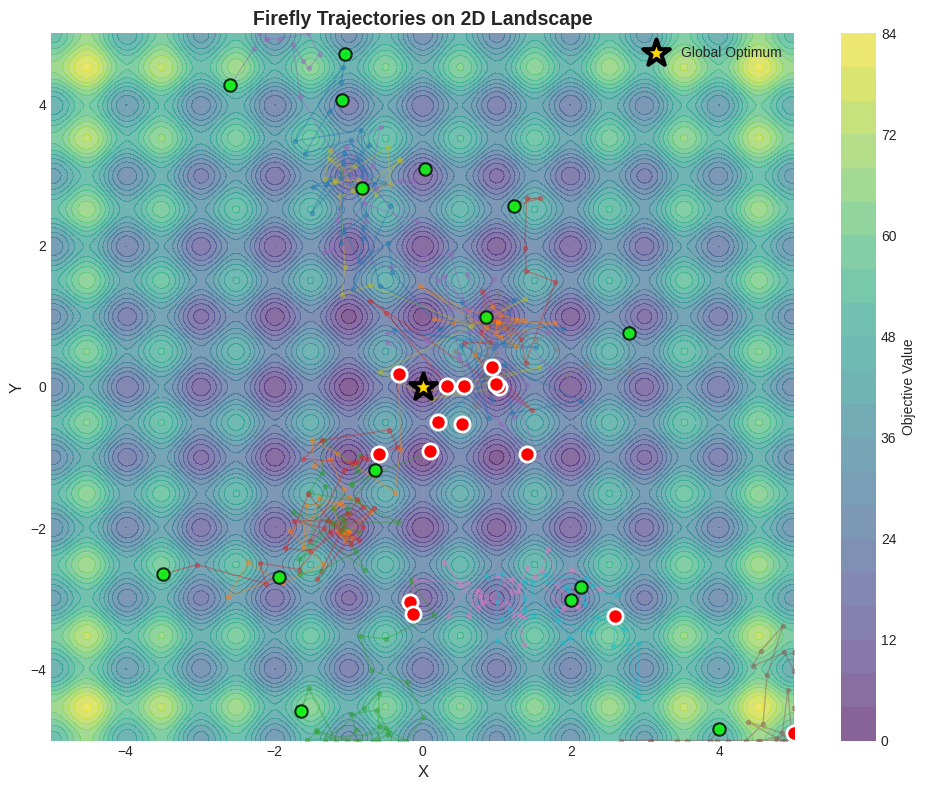

In [9]:
# Alternative: show trails (trajectory lines)
fig, ax = plt.subplots(figsize=(10, 8))

# Plot contour
contour = ax.contourf(X, Y, Z, levels=25, cmap='viridis', alpha=0.6)
plt.colorbar(contour, ax=ax, label='Objective Value')

# Plot trajectory for each firefly
for firefly_idx in range(fa_2d.n):
    path = np.array([traj[firefly_idx] for traj in trajectory])
    ax.plot(path[:, 0], path[:, 1], 'o-', alpha=0.4, linewidth=1, markersize=3)
    
    # Mark start (green) and end (red)
    ax.scatter(path[0, 0], path[0, 1], c='lime', s=80, marker='o', 
              edgecolors='black', linewidth=1.5, zorder=5, alpha=0.8)
    ax.scatter(path[-1, 0], path[-1, 1], c='red', s=120, marker='o', 
              edgecolors='white', linewidth=2, zorder=5)

# Mark global optimum
ax.scatter(0, 0, c='gold', s=400, marker='*', 
          edgecolors='black', linewidth=3, zorder=10, label='Global Optimum')

ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.set_title('Firefly Trajectories on 2D Landscape', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Ứng dụng vào hàm Rastrigin (liên tục, nhiều chiều)

**Hàm Rastrigin** là một benchmark kinh điển trong tối ưu hóa:

* **Đa cực trị mạnh** (rất nhiều nghiệm cục bộ)
* **Không tách được** khi số chiều tăng
* Nghiệm toàn cục tại (\mathbf{x} = \mathbf{0}) với (f(\mathbf{0}) = 0)

Công thức:
[
f(\mathbf{x}) = An + \sum_{i=1}^{n}\left[x_i^2 - A\cos(2\pi x_i)\right],\quad A = 10
]

Ở đây sẽ sử dụng **triển khai FA sẵn có** trong repository này.

---


In [10]:
import sys
import os

# Add parent directory to path
sys.path.append(os.path.dirname(os.path.abspath('')))

from src.problems.continuous.rastrigin import RastriginProblem
from src.swarm.fa import FireflyContinuousOptimizer

print("✓ Imported project's FA implementation")

✓ Imported project's FA implementation


In [11]:
# Setup Rastrigin problem in 10 dimensions
dim = 10
problem = RastriginProblem(dim=dim)

# Configure FA
fa_rastrigin = FireflyContinuousOptimizer(
    problem=problem,
    n_fireflies=30,
    alpha=0.2,
    beta0=1.0,
    gamma=1.0,
    seed=42
)

# Run optimization
print(f"Running FA on {dim}D Rastrigin...")
best_solution, best_fitness, history, _ = fa_rastrigin.run(max_iter=100)

print(f"\n✓ Optimization complete!")
print(f"Best fitness found: {best_fitness:.6f}")
print(f"Global optimum: 0.0")
print(f"Initial fitness: {history[0]:.6f}")
print(f"Improvement: {history[0] - best_fitness:.6f}")

Running FA on 10D Rastrigin...

✓ Optimization complete!
Best fitness found: 92.711095
Global optimum: 0.0
Initial fitness: 115.624344
Improvement: 22.913249

✓ Optimization complete!
Best fitness found: 92.711095
Global optimum: 0.0
Initial fitness: 115.624344
Improvement: 22.913249


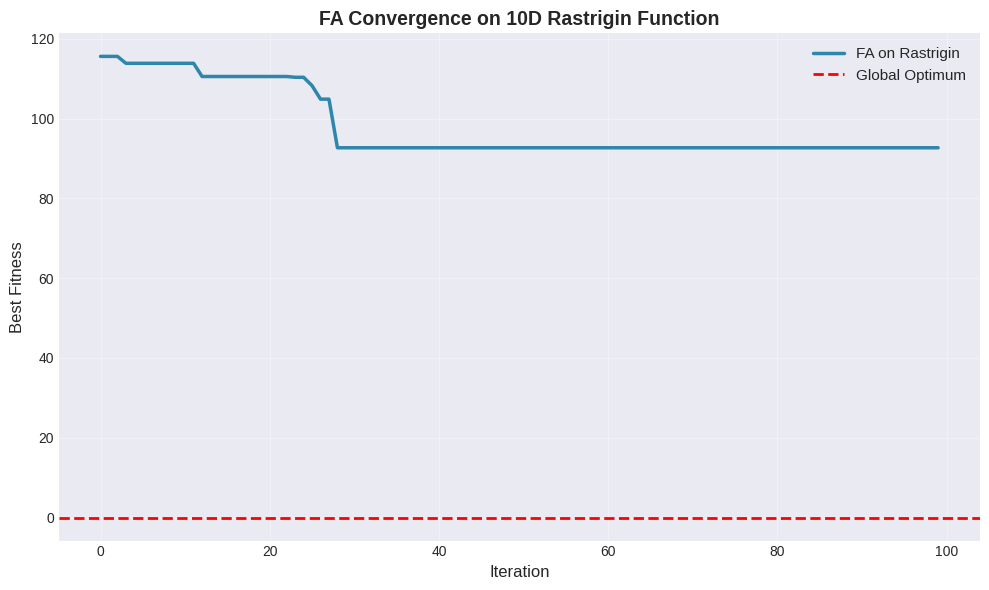

📊 Observations:
   - FA quickly improves in early iterations
   - Convergence slows as it approaches local/global optima
   - In high dimensions, reaching exact global optimum (0.0) is very difficult


In [12]:
# Plot convergence curve for Rastrigin
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(history, linewidth=2.5, color='#2E86AB', label='FA on Rastrigin')
ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Global Optimum')

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Best Fitness', fontsize=12)
ax.set_title(f'FA Convergence on {dim}D Rastrigin Function', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"📊 Observations:")
print(f"   - FA quickly improves in early iterations")
print(f"   - Convergence slows as it approaches local/global optima")
print(f"   - In high dimensions, reaching exact global optimum (0.0) is very difficult")


## 4. Ứng dụng vào bài toán Knapsack 0–1 (rời rạc/tổ hợp)

**Knapsack 0–1** là một bài toán tối ưu tổ hợp kinh điển:

* Cho (n) vật phẩm, mỗi vật có giá trị (v_i) và trọng lượng (w_i)
* Chọn một tập con để tối đa hóa tổng giá trị
* Ràng buộc: tổng trọng lượng ≤ sức chứa (C)

**Thách thức:** FA được thiết kế cho không gian liên tục, nên bản triển khai sử dụng:

* **Mã hóa nhị phân** (0 = không chọn vật, 1 = chọn vật)
* **Cơ chế sửa lỗi (repair)** để đảm bảo nghiệm hợp lệ (tổng trọng lượng ≤ sức chứa)
* **Di chuyển rời rạc** bằng cách lật bit theo xác suất

Ở đây sẽ dùng phiên bản FA dành cho Knapsack đã có trong repository.


In [13]:
from src.problems.discrete.knapsack import KnapsackProblem
from src.swarm.fa import FireflyKnapsackOptimizer

print("✓ Imported Knapsack problem and FA optimizer")

✓ Imported Knapsack problem and FA optimizer


In [14]:
# Create a Knapsack instance
np.random.seed(123)
n_items = 30
values = np.random.randint(10, 100, n_items)
weights = np.random.randint(5, 50, n_items)
capacity = int(0.5 * np.sum(weights))  # 50% of total weight

problem_knapsack = KnapsackProblem(values, weights, capacity)

print(f"Knapsack Problem:")
print(f"  Number of items: {n_items}")
print(f"  Capacity: {capacity}")
print(f"  Total weight if all taken: {np.sum(weights)}")
print(f"  Total value if all taken: {np.sum(values)}")

Knapsack Problem:
  Number of items: 30
  Capacity: 395
  Total weight if all taken: 791
  Total value if all taken: 1950


In [15]:
# Configure FA for Knapsack
fa_knapsack = FireflyKnapsackOptimizer(
    problem=problem_knapsack,
    n_fireflies=25,
    alpha_flip=0.2,
    max_flips_per_move=3,
    seed=42
)

# Run optimization
print(f"\nRunning FA on Knapsack...")
best_solution, best_fitness, history, _ = fa_knapsack.run(max_iter=100)

# FA returns negative fitness (for minimization), negate to get actual value
best_value = -best_fitness
best_weight = np.sum(best_solution * weights)

print(f"\n✓ Optimization complete!")
print(f"Best total value: {best_value:.0f}")
print(f"Best total weight: {best_weight} / {capacity}")
print(f"Feasible: {best_weight <= capacity}")
print(f"Items selected: {np.sum(best_solution)} / {n_items}")
print(f"Initial value: {-history[0]:.0f}")
print(f"Improvement: {best_value - (-history[0]):.0f}")


Running FA on Knapsack...

✓ Optimization complete!
Best total value: 1516
Best total weight: 394 / 395
Feasible: True
Items selected: 21 / 30
Initial value: 1448
Improvement: 68

✓ Optimization complete!
Best total value: 1516
Best total weight: 394 / 395
Feasible: True
Items selected: 21 / 30
Initial value: 1448
Improvement: 68


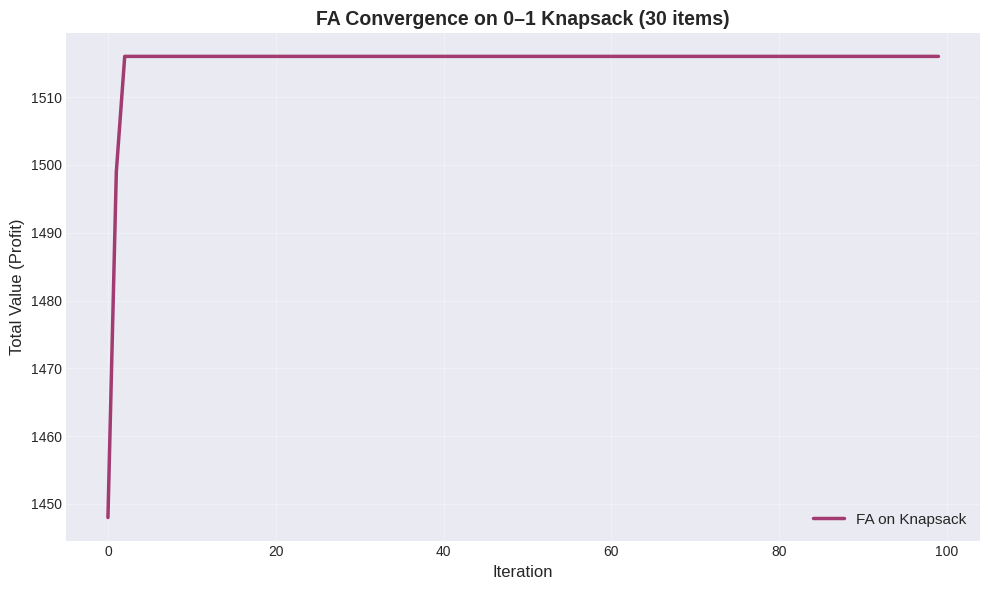

📊 Observations:
   - Rapid improvement in early iterations (greedy-like behavior)
   - Convergence plateaus as feasible space is explored
   - Discrete nature causes step-like improvements


In [16]:
# Plot convergence curve for Knapsack (negate for actual values)
fig, ax = plt.subplots(figsize=(10, 6))

actual_values = [-h for h in history]  # Convert to maximization (total value)
ax.plot(actual_values, linewidth=2.5, color='#A23B72', label='FA on Knapsack')

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Total Value (Profit)', fontsize=12)
ax.set_title(f'FA Convergence on 0–1 Knapsack ({n_items} items)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"📊 Observations:")
print(f"   - Rapid improvement in early iterations (greedy-like behavior)")
print(f"   - Convergence plateaus as feasible space is explored")
print(f"   - Discrete nature causes step-like improvements")

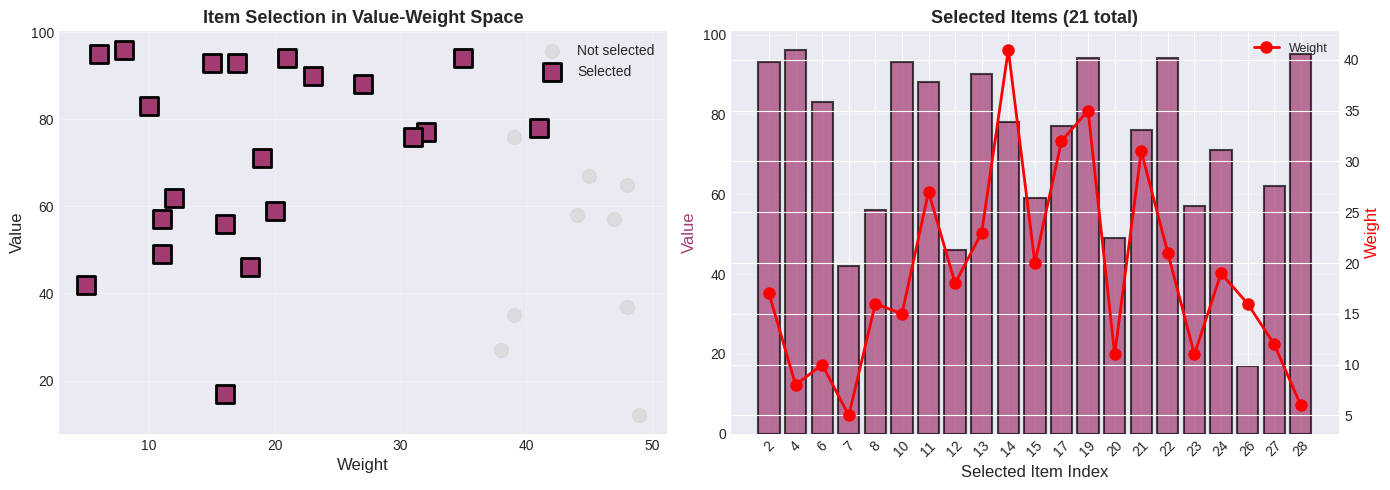

In [17]:
# Visualize the solution: which items were selected?
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: value and weight of all items
ax1.scatter(weights, values, c='lightgray', s=100, alpha=0.6, label='Not selected')
selected_mask = best_solution == 1
ax1.scatter(weights[selected_mask], values[selected_mask], 
           c='#A23B72', s=150, marker='s', edgecolors='black', linewidth=2,
           label='Selected', zorder=5)

ax1.set_xlabel('Weight', fontsize=12)
ax1.set_ylabel('Value', fontsize=12)
ax1.set_title('Item Selection in Value-Weight Space', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Right plot: bar chart of selected items
selected_indices = np.where(selected_mask)[0]
selected_vals = values[selected_mask]
selected_wts = weights[selected_mask]

x_pos = np.arange(len(selected_indices))
bars = ax2.bar(x_pos, selected_vals, color='#A23B72', alpha=0.7, edgecolor='black', linewidth=1.5)

# Overlay weights as line
ax2_twin = ax2.twinx()
ax2_twin.plot(x_pos, selected_wts, 'o-', color='red', linewidth=2, markersize=8, label='Weight')

ax2.set_xlabel('Selected Item Index', fontsize=12)
ax2.set_ylabel('Value', fontsize=12, color='#A23B72')
ax2_twin.set_ylabel('Weight', fontsize=12, color='red')
ax2.set_title(f'Selected Items ({len(selected_indices)} total)', fontsize=13, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(selected_indices, rotation=45)
ax2_twin.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## 5. So sánh: Rastrigin và Knapsack

Cùng quan sát trực quan sự khác biệt trong hành vi hội tụ trên hai bài toán.


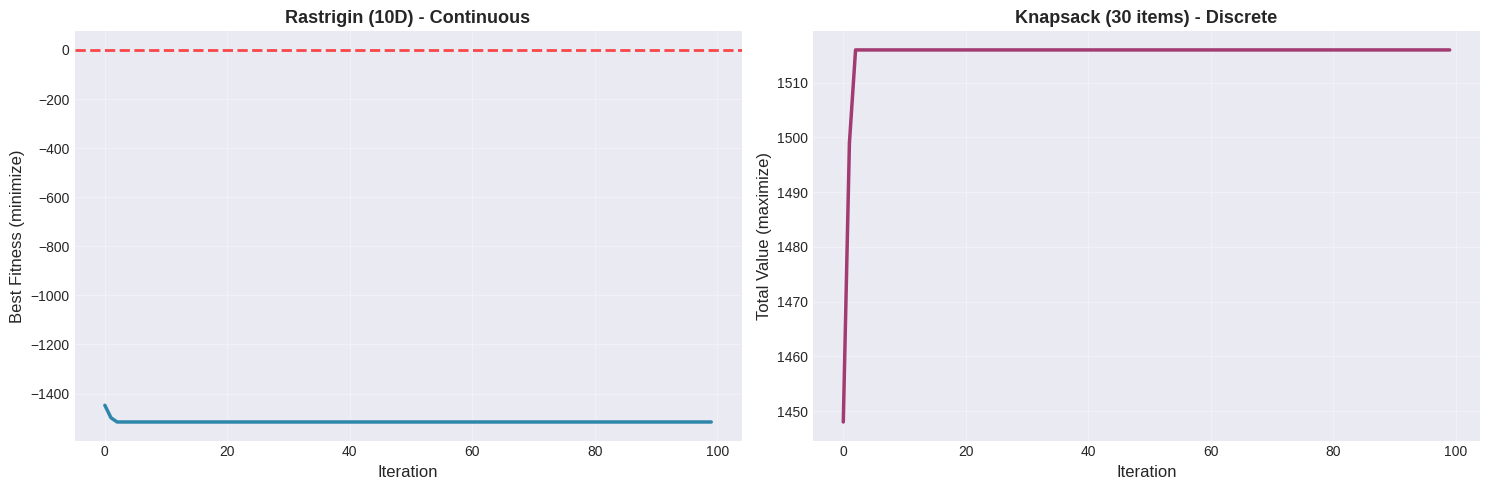

📊 Key differences:
   - Rastrigin: smooth continuous convergence, harder to reach global optimum
   - Knapsack: step-like discrete improvements, fast early gains, then plateau


In [18]:
# Side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Rastrigin
ax1.plot(history, linewidth=2.5, color='#2E86AB')
ax1.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Best Fitness (minimize)', fontsize=12)
ax1.set_title(f'Rastrigin ({dim}D) - Continuous', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Knapsack
actual_values_knapsack = [-h for h in history]
ax2.plot(actual_values_knapsack, linewidth=2.5, color='#A23B72')
ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('Total Value (maximize)', fontsize=12)
ax2.set_title(f'Knapsack ({n_items} items) - Discrete', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Key differences:")
print("   - Rastrigin: smooth continuous convergence, harder to reach global optimum")
print("   - Knapsack: step-like discrete improvements, fast early gains, then plateau")

## 6. Tổng kết và các điểm cần trình bày

**Firefly Algorithm là gì?**

* Metaheuristic lấy cảm hứng từ thiên nhiên, dựa trên sự hấp dẫn giữa các đom đóm
* Thuật toán dựa trên quần thể: duy trì nhiều nghiệm ứng viên
* Chuyển động được dẫn dắt bởi độ hấp dẫn (độ sáng) và yếu tố ngẫu nhiên
* Các tham số (\alpha), (\beta_0), (\gamma) điều khiển cân bằng giữa khám phá và khai thác

**Nhận xét từ minh họa 2D:**

* Đom đóm tụ lại quanh các vùng hứa hẹn
* Thành phần ngẫu nhiên giúp tránh hội tụ sớm
* Cơ chế hấp dẫn cân bằng giữa tìm kiếm cục bộ và toàn cục

**Rastrigin (liên tục, đa cực trị):**

* FA cải thiện nghiệm dần qua các vòng lặp
* Bề mặt cực trị dày đặc khiến việc đạt nghiệm tối ưu toàn cục trở nên khó
* Đường hội tụ mượt, kiểu điển hình của tối ưu liên tục
* Hiệu năng phụ thuộc vào tinh chỉnh tham số (đặc biệt (\gamma) quyết định mức cục bộ)

**Knapsack (rời rạc, tổ hợp):**

* FA được chỉnh để hoạt động trong không gian rời rạc qua mã hóa nhị phân + repair
* Cải thiện mạnh ở giai đoạn đầu nhờ cơ chế sửa nghiệm hợp lệ
* Xuất hiện plateau khi thuật toán tìm được nghiệm giá trị cao, khó cải thiện thêm
* Đường hội tụ dạng bậc phản ánh tính rời rạc của bài toán

**Điểm mạnh của FA:**

* Ẩn dụ trực quan, dễ giải thích
* Linh hoạt: áp dụng được cho cả bài toán liên tục và rời rạc
* Dựa trên quần thể: khám phá đồng thời nhiều vùng
* Ít tham số hơn một số metaheuristic khác

**Hạn chế:**

* Không có đảm bảo tìm được nghiệm tối ưu toàn cục (như các metaheuristic khác)
* Nhạy với việc chọn tham số
* Chậm trên bài toán rất nhiều chiều
* Cần thích nghi theo từng bài toán rời rạc

**Tổng quan:**
FA là một công cụ tối ưu hóa đa dụng. Nó hoạt động tốt trên các bài toán có độ phức tạp vừa phải và cho nghiệm tốt khi các phương pháp chính xác không khả thi. Cốt lõi nằm ở hiểu cấu trúc bài toán và tinh chỉnh tham số hợp lý.

---

**Kết thúc Notebook** 🔥
